In [1]:
#using Distributed
#@everywhere using MambaModels
using MambaModels
gr(size=(400,400))

# Data
line = Dict{Symbol, Any}()

howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [2]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight])
df2[:weight_c] = convert(Vector{Float64}, df2[:weight]) .- mean_weight ;
line[:x] = convert(Array{Float64,1}, df2[:weight_c]);
line[:y] = convert(Array{Float64,1}, df2[:height]);
line[:xmat] = convert(Array{Float64,2}, [ones(length(line[:x])) line[:x]])

352×2 Array{Float64,2}:
 1.0    2.83512
 1.0   -8.50468
 1.0  -13.1256 
 1.0    8.05143
 1.0   -3.71361
 1.0   18.0021 
 1.0   -6.74701
 1.0   10.4895 
 1.0  -10.1206 
 1.0    9.49725
 ⋮             
 1.0    2.89182
 1.0   -5.58468
 1.0   -3.94041
 1.0   -4.16721
 1.0    2.04133
 1.0  -10.7443 
 1.0    7.17259
 1.0    9.07201
 1.0    7.54114

Model Specification

In [3]:
model = Model(
  y = Stochastic(1,
    (xmat, beta, s2) -> MvNormal(xmat * beta, sqrt(s2)),
    false
  ),
  beta = Stochastic(1, () -> MvNormal([178, 0], [sqrt(10000), sqrt(100)])),
  s2 = Stochastic(() -> Uniform(0, 50))
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


Initial Values

In [4]:
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],
    :beta => [rand(Normal(178, 100)), rand(Normal(0, 10))],
    :s2 => rand(Uniform(0, 50))
  )
  for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[66.4983, 1.47775],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>27.8944)
 Dict(:beta=>[319.991, 1.7952],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>45.6557) 
 Dict(:beta=>[56.053, -11.993],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>22.6681) 

Tuning Parameters

In [5]:
scale1 = [0.5, 0.25]
summary1 = identity
eps1 = 0.5

scale2 = 0.5
summary2 = x -> [mean(x); sqrt(var(x))]
eps2 = 0.1

0.1

Define sampling scheme

In [6]:
scheme = [
  Mamba.NUTS([:beta]),
  Mamba.Slice([:s2], 10)
]

setsamplers!(model, scheme)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


MCMC Simulation

In [7]:
chn = mcmc(model, line, inits, 10000, burnin=1000, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:12:32 of 0:12:32 remaining]
Chain 1:  10% [0:00:10 of 0:00:11 remaining]
Chain 1:  20% [0:00:06 of 0:00:08 remaining]
Chain 1:  30% [0:00:05 of 0:00:06 remaining]
Chain 1:  40% [0:00:04 of 0:00:06 remaining]
Chain 1:  50% [0:00:03 of 0:00:05 remaining]
Chain 1:  60% [0:00:02 of 0:00:05 remaining]
Chain 1:  70% [0:00:02 of 0:00:05 remaining]
Chain 1:  80% [0:00:01 of 0:00:05 remaining]
Chain 1:  90% [0:00:00 of 0:00:05 remaining]
Chain 1: 100% [0:00:00 of 0:00:05 remaining]

Chain 2:   0% [0:00:02 of 0:00:02 remaining]
Chain 2:  10% [0:00:03 of 0:00:04 remaining]
Chain 2:  20% [0:00:03 of 0:00:04 remaining]
Chain 2:  30% [0:00:03 of 0:00:04 remaining]
Chain 2:  40% [0:00:02 of 0:00:04 remaining]
Chain 2:  50% [0:00:02 of 0:00:04 remaining]
Chain 2:  60% [0:00:02 of 0:00:04 remaining]
Chain 2:  70% [0:00:01 of 0:00:04 remaining]
Chain 2:  80% [0:00:01 of 0:00:04 remaining]
Chain 2:  90% [0:00:00 of 0:00:04 remaining]
Cha

Object of type "ModelChains"

Iterations = 1001:10000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 9000

[24.43 155.038 0.883965; 27.3274 154.493 0.883398; … ; 23.6971 154.78 0.848106; 25.6506 154.694 0.89081]

[25.0226 154.752 0.907752; 24.9145 155.098 0.868625; … ; 27.347 154.027 0.857419; 29.042 154.363 0.852928]

[25.8851 154.671 0.961965; 28.9402 154.671 0.961965; … ; 25.7767 154.496 1.00636; 26.1087 154.576 0.848002]

Show draws summary

In [8]:
describe(chn)

Iterations = 1001:10000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 9000

Empirical Posterior Estimates:
            Mean          SD        Naive SE        MCSE        ESS   
     s2  26.22358705 2.033559882 0.01237585132 0.02061977237 9000.0000
beta[1] 154.59732590 0.273973161 0.00166734756 0.00390007562 4934.8049
beta[2]   0.90497214 0.042594154 0.00025921976 0.00033565621 9000.0000

Quantiles:
            2.5%        25.0%        50.0%        75.0%        97.5%   
     s2  22.5412343  24.81688782  26.12671148  27.52396636  30.50382553
beta[1] 154.0545514 154.41100516 154.60094152 154.78241735 155.13616350
beta[2]   0.8216732   0.87580553   0.90508605   0.93398964   0.98895453



Convert to MCMCChains.Chains object

In [9]:
chn2 = MCMCChains.Chains(chn.value, Symbol.(chn.names))

Object of type "MCMCChains.Chains{Float64,Float64,NamedTuple{(:parameters,),Tuple{Array{Any,1}}},NamedTuple{(),Tuple{}}}"

Iterations        = 1:9000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3
Samples per chain = 9000
parameters        = s2, beta[1], beta[2]



Describe the MCMCChains

In [10]:
MCMCChains.describe(chn2)

Iterations        = 1:9000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3
Samples per chain = 9000
parameters        = s2, beta[1], beta[2]

Empirical Posterior Estimates:
parameters
          Mean     SD   Naive SE  MCSE     ESS   
beta[1] 154.5973 0.2740   0.0017 0.0039 4934.8049
beta[2]   0.9050 0.0426   0.0003 0.0003 9000.0000
     s2  26.2236 2.0336   0.0124 0.0206 9000.0000

Quantiles:
parameters
          2.5%     25.0%    50.0%    75.0%    97.5% 
beta[1] 153.5426 154.4110 154.6009 154.7824 155.5975
beta[2]   0.7198   0.8758   0.9051   0.9340   1.0939
     s2  19.6703  24.8169  26.1267  27.5240  35.3103



Plot chn2

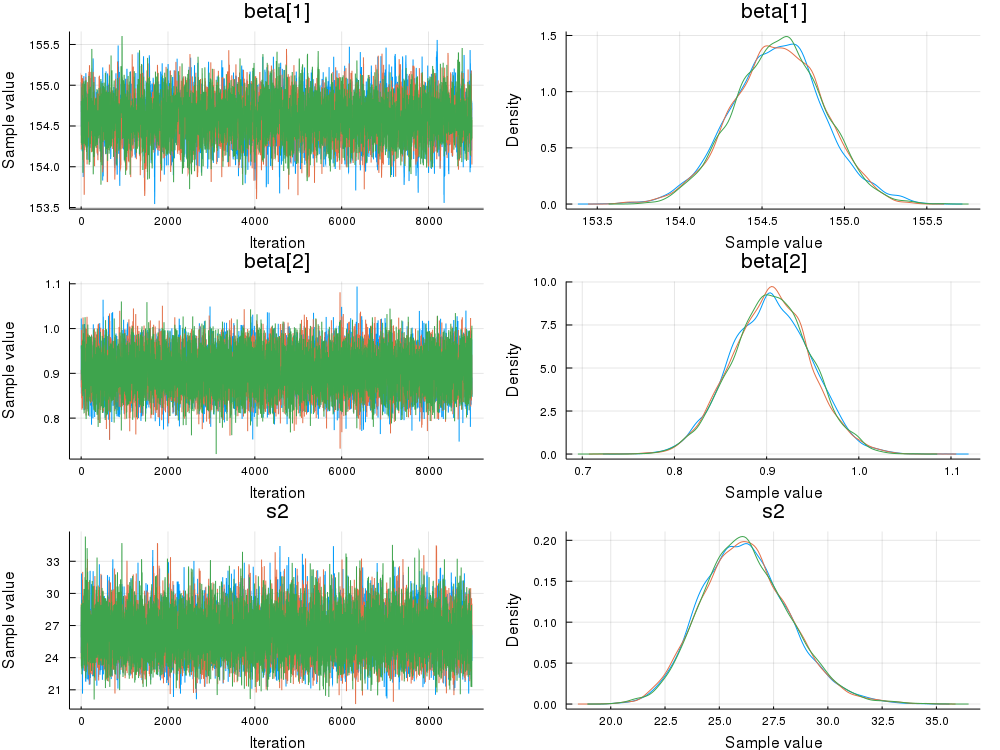

In [11]:
MCMCChains.plot(chn2)

End of `04/m4.1m.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*